# Capstone EDA & Baseline Model – Santander Product Recommendation

**Goal:** Explore the Santander customer data and build a baseline model  
that predicts whether a customer will hold a chosen product, as a first step  
toward a recommendation system.

Dataset: **Santander Customer Transaction Prediction / Product Recommendation (Kaggle)**  
File used here: `train_ver2.csv` (subset for memory reasons).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)

sns.set(style="whitegrid", context="notebook")


## 1. Load Data

In [2]:
DATA_PATH = "data/train_ver2.csv"   
N_ROWS = 1500000                     

df = pd.read_csv(DATA_PATH, nrows=N_ROWS)

print("Shape:", df.shape)
df.head()

Shape: (1500000, 48)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


## 2. Quick Data Overview

In [3]:
print("Columns:", df.columns.tolist())
print("\nInfo:")
print(df.info())

# Fraction of missing values
missing = df.isna().mean().sort_values(ascending=False)
print("\nFraction of missing values per column:")
print(missing.head(20))

# Identify product columns
product_cols = [c for c in df.columns if c.startswith("ind_") and c.endswith("_ult1")]
non_product_cols = [c for c in df.columns if c not in product_cols]

print(f"\nNumber of product columns: {len(product_cols)}")
print("Sample product columns:", product_cols[:10])


Columns: ['fecha_dato', 'ncodpers', 'ind_empleado', 'pais_residencia', 'sexo', 'age', 'fecha_alta', 'ind_nuevo', 'antiguedad', 'indrel', 'ult_fec_cli_1t', 'indrel_1mes', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp', 'canal_entrada', 'indfall', 'tipodom', 'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta', 'segmento', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 48 columns):
 #   Column                 Non-Null Count    Dtype  
--- 

## 3. Basic Cleaning

In [4]:
# Remove exact duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed {before - after} duplicate rows.")

# Age
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["age"] = df["age"].clip(lower=18, upper=99)

# Income
if "renta" in df.columns:
    df["renta"] = pd.to_numeric(df["renta"], errors="coerce")

# Dates
if "fecha_dato" in df.columns:
    df["fecha_dato"] = pd.to_datetime(df["fecha_dato"], errors="coerce")
if "fecha_alta" in df.columns:
    df["fecha_alta"] = pd.to_datetime(df["fecha_alta"], errors="coerce")

# Seniority
if "antiguedad" in df.columns:
    df["antiguedad"] = pd.to_numeric(df["antiguedad"], errors="coerce")
    df["antiguedad"] = df["antiguedad"].clip(lower=0)

# Number of products held
df["num_products"] = df[product_cols].sum(axis=1)

df[["age", "renta", "antiguedad", "num_products"]].describe()


Removed 0 duplicate rows.


,age,renta,antiguedad,num_products
count,1.484638e+06,1.236075e+06,1.484638e+06,1.500000e+06
mean,4.222066e+01,1.376281e+05,9.115876e+01,1.851483e+00
std,1.697019e+01,2.285082e+05,6.530568e+01,1.593735e+00
min,1.800000e+01,1.202730e+03,0.000000e+00,0.000000e+00
25%,2.600000e+01,7.069650e+04,3.300000e+01,1.000000e+00
50%,4.200000e+01,1.052366e+05,8.300000e+01,1.000000e+00
75%,5.200000e+01,1.611747e+05,1.460000e+02,2.000000e+00
max,9.900000e+01,2.889440e+07,2.460000e+02,1.500000e+01


## 4. Exploratory Data Analysis (EDA)

### 4.1 Distributions of key numeric variables

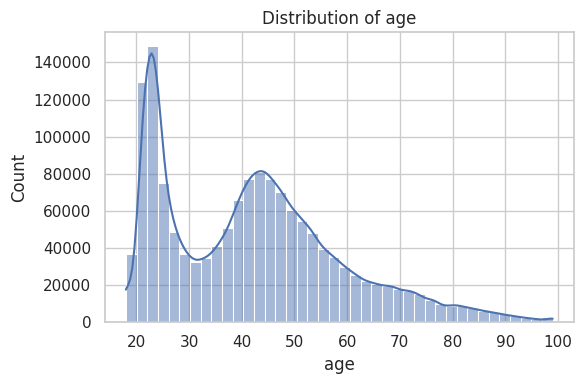

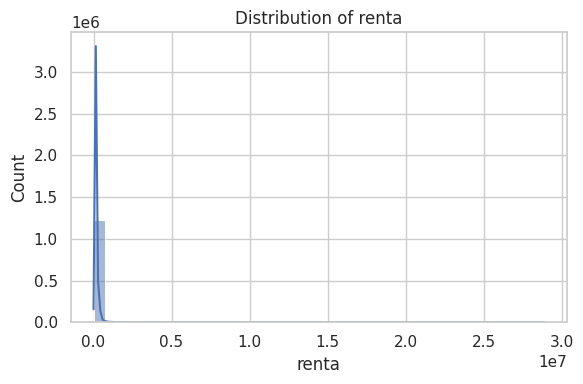

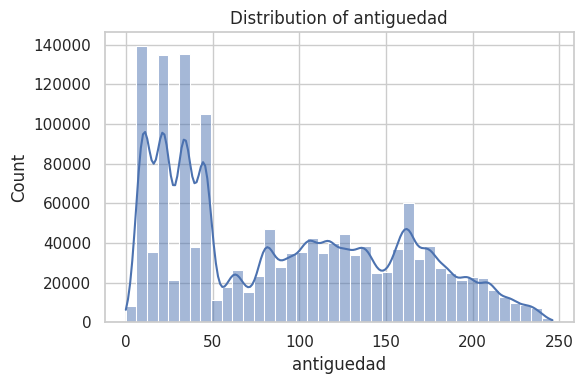

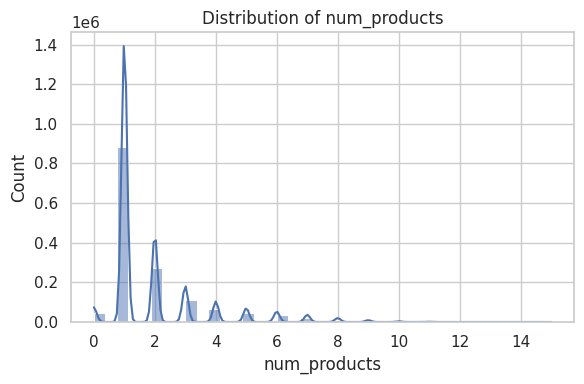

In [5]:
numeric_cols = ["age", "renta", "antiguedad", "num_products"]

for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col].dropna(), bins=40, kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


### 4.2 Categorical Variables


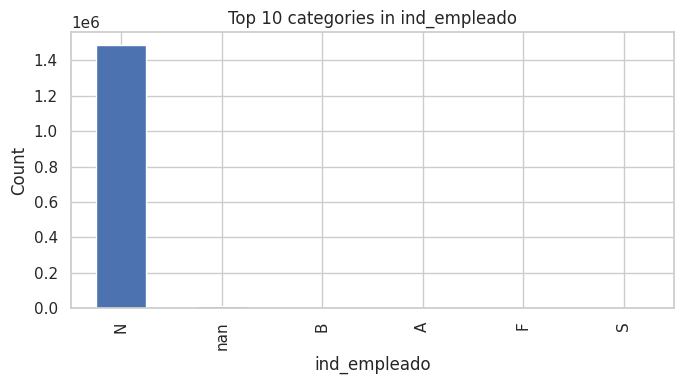

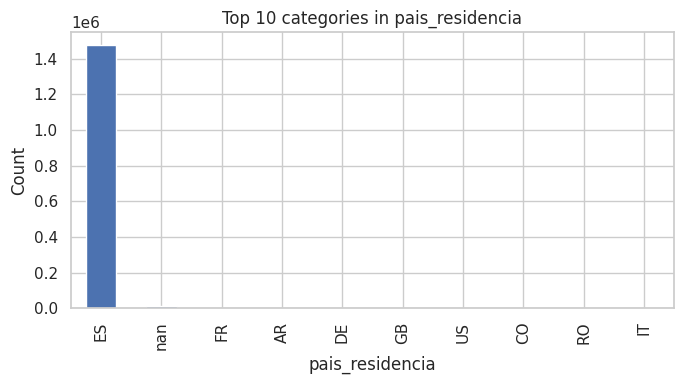

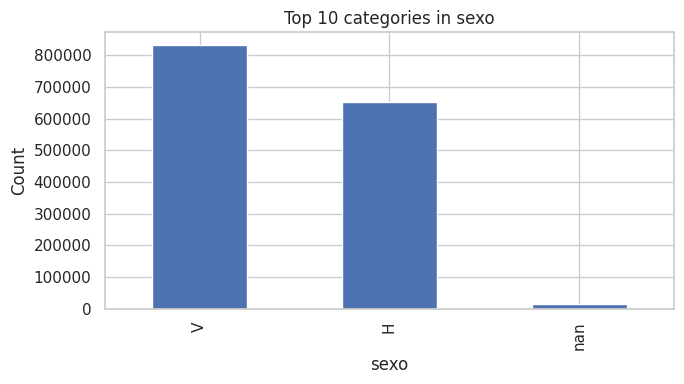

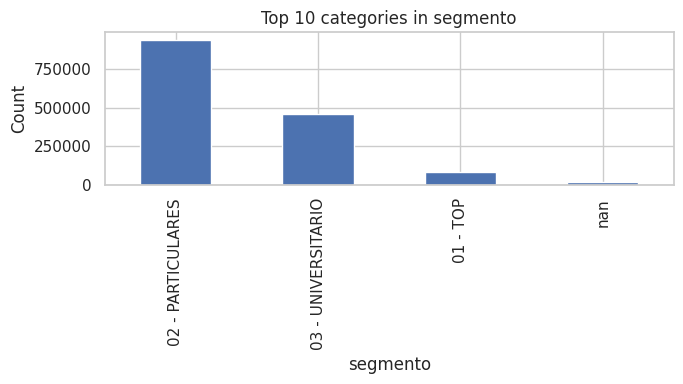

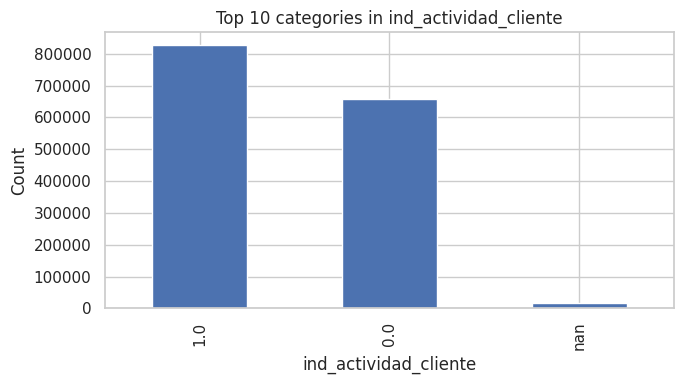

In [6]:
categorical_preview_cols = [
    "ind_empleado", "pais_residencia", "sexo",
    "segmento", "ind_actividad_cliente"
]

for col in categorical_preview_cols:
    if col in df.columns:
        plt.figure(figsize=(7, 4))
        df[col].value_counts(dropna=False).head(10).plot(kind="bar")
        plt.title(f"Top 10 categories in {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


### 4.3 Product Ownership Rates


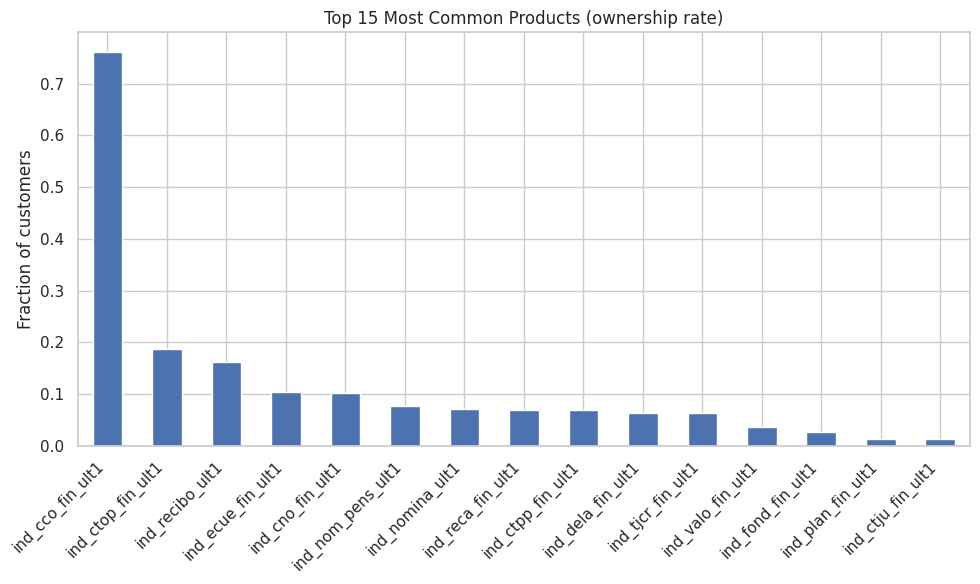

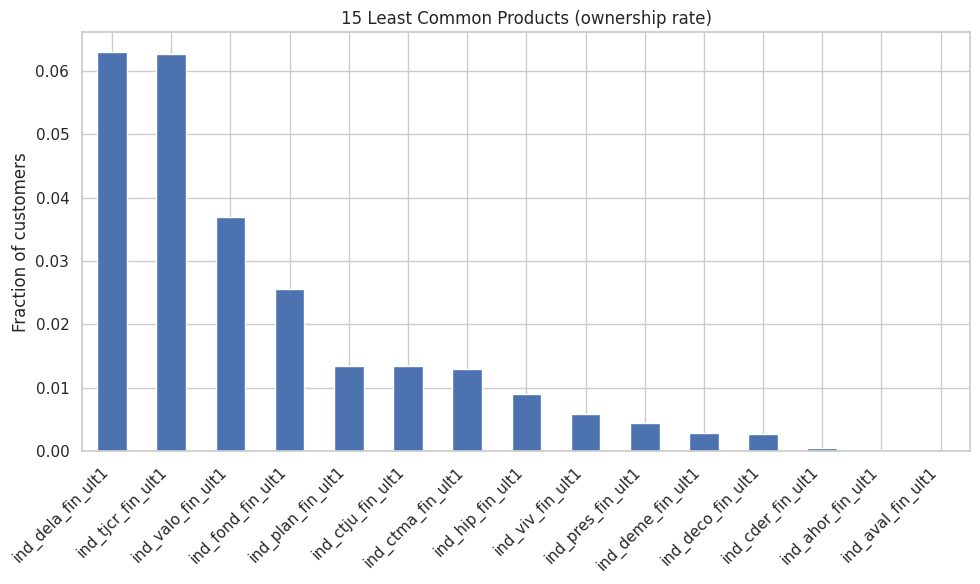

In [7]:
product_means = df[product_cols].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
product_means.head(15).plot(kind="bar")
plt.title("Top 15 Most Common Products (ownership rate)")
plt.ylabel("Fraction of customers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
product_means.tail(15).plot(kind="bar")
plt.title("15 Least Common Products (ownership rate)")
plt.ylabel("Fraction of customers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 4.4 Relationships Between Features

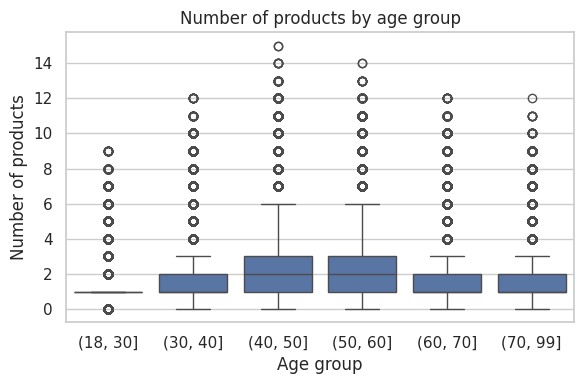

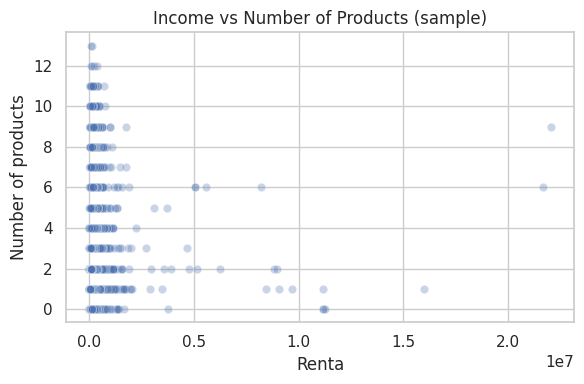

In [8]:
# Age group vs number of products
plt.figure(figsize=(6, 4))
age_bins = [18, 30, 40, 50, 60, 70, 99]
sns.boxplot(
    x=pd.cut(df["age"], bins=age_bins),
    y="num_products",
    data=df
)
plt.title("Number of products by age group")
plt.xlabel("Age group")
plt.ylabel("Number of products")
plt.tight_layout()
plt.show()

# Income vs number of products (sample)
if "renta" in df.columns:
    sample = df.dropna(subset=["renta"]).sample(
        min(50000, df.dropna(subset=["renta"]).shape[0]),
        random_state=42
    )
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=sample,
        x="renta",
        y="num_products",
        alpha=0.3
    )
    plt.title("Income vs Number of Products (sample)")
    plt.xlabel("Renta")
    plt.ylabel("Number of products")
    plt.tight_layout()
    plt.show()


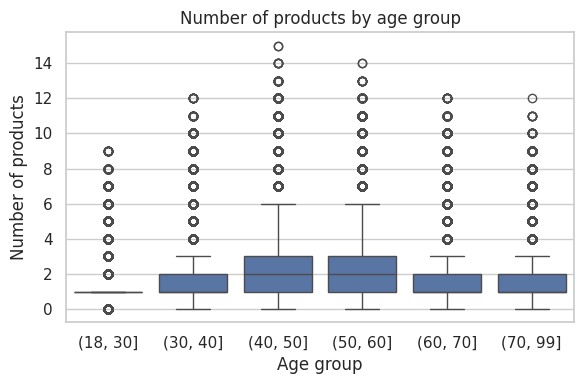

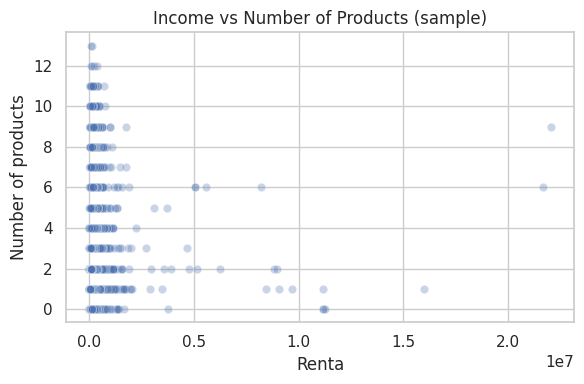

In [9]:
# Age group vs number of products
plt.figure(figsize=(6, 4))
age_bins = [18, 30, 40, 50, 60, 70, 99]
sns.boxplot(
    x=pd.cut(df["age"], bins=age_bins),
    y="num_products",
    data=df
)
plt.title("Number of products by age group")
plt.xlabel("Age group")
plt.ylabel("Number of products")
plt.tight_layout()
plt.show()

# Income vs number of products (sample)
if "renta" in df.columns:
    sample = df.dropna(subset=["renta"]).sample(
        min(50000, df.dropna(subset=["renta"]).shape[0]),
        random_state=42
    )
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=sample,
        x="renta",
        y="num_products",
        alpha=0.3
    )
    plt.title("Income vs Number of Products (sample)")
    plt.xlabel("Renta")
    plt.ylabel("Number of products")
    plt.tight_layout()
    plt.show()


In [10]:
TARGET_PRODUCT = "ind_tjcr_fin_ult1" 

if TARGET_PRODUCT not in df.columns:
    raise ValueError(
        f"{TARGET_PRODUCT} not found. Example product columns: {product_cols[:5]}"
    )

# Drop rows with missing target
df_model = df.dropna(subset=[TARGET_PRODUCT]).copy()

# Label
y = df_model[TARGET_PRODUCT].astype(int)

# Feature set: demographic + behavior + engineered feature
X = df_model[non_product_cols + ["num_products"]].copy()

# Drop date columns to avoid issues in one-hot encoding
date_cols = [c for c in X.columns if "fecha" in c]
X = X.drop(columns=date_cols)

print("Shape of X, y:", X.shape, y.shape)


Shape of X, y: (1500000, 23) (1500000,)


### 5.1 Split into Train and Test Sets


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1200000, 23)
Test shape: (300000, 23)


### 5.2 Preprocessing and Model Pipeline

In [12]:
# Identify numeric vs categorical features
numeric_features = []
categorical_features = []

for col in X_train.columns:
    if np.issubdtype(X_train[col].dtype, np.number):
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print("Numeric features example:", numeric_features[:10])
print("Categorical features example:", categorical_features[:10])

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

clf


Numeric features example: ['ncodpers', 'age', 'ind_nuevo', 'antiguedad', 'indrel', 'indrel_1mes', 'tipodom', 'cod_prov', 'ind_actividad_cliente', 'renta']
Categorical features example: ['ind_empleado', 'pais_residencia', 'sexo', 'ult_fec_cli_1t', 'tiprel_1mes', 'indresi', 'indext', 'conyuemp', 'canal_entrada', 'indfall']


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 5.3 Fit the Model


In [13]:
clf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 6. Evaluation


ROC AUC:    0.944
Precision:  0.644
Recall:     0.380
F1 Score:   0.478

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    281195
           1       0.64      0.38      0.48     18805

    accuracy                           0.95    300000
   macro avg       0.80      0.68      0.73    300000
weighted avg       0.94      0.95      0.94    300000



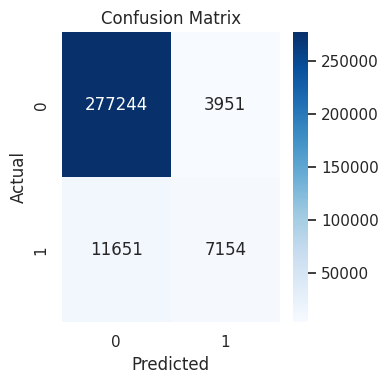

In [14]:
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, y_proba)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC AUC:    {roc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1 Score:   {f1:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## 7. Simple Popularity Baseline


In [15]:
y_pred_pop = np.ones_like(y_test)

prec_pop = precision_score(y_test, y_pred_pop)
rec_pop = recall_score(y_test, y_pred_pop)
f1_pop = f1_score(y_test, y_pred_pop)

print("=== Popularity Baseline (always predict product) ===")
print(f"Precision: {prec_pop:.3f}")
print(f"Recall:    {rec_pop:.3f}")
print(f"F1 Score:  {f1_pop:.3f}")

print("\n=== Logistic Regression vs Baseline ===")
print(f"LogReg F1: {f1:.3f} | Baseline F1: {f1_pop:.3f}")


=== Popularity Baseline (always predict product) ===
Precision: 0.063
Recall:    1.000
F1 Score:  0.118

=== Logistic Regression vs Baseline ===
LogReg F1: 0.478 | Baseline F1: 0.118
